<!--
authors: Matthew Wilson, Daniele Reda
created: 2020/01/14
last_updated: 2020/01/27
-->


## CPSC 533V: Assignment 3 - Tabular Q Learning using OpenAI Gym environments

---

##  Tabular Q-Learning

Tabular Q-learning is an RL algorithm for problems with discrete states and discrete actions. The algorithm is described in the class notes, which borrows the summary description from [Section 6.5](http://incompleteideas.net/book/RLbook2018.pdf#page=153) of Richard Sutton's RL book. In the tabular approach, the Q-value is represented as a lookup table. As discussed in class, Q-learning can further be extended to continuous states and discrete actions, leading to the [Atari DQN](https://arxiv.org/abs/1312.5602) / Deep Q-learning algorithm.  However, it is important and informative to first fully understand tabular Q-learning.

Informally, Q-learning works as follows: The goal is to the perfectly learn the optimal Q-function: 
`Q(s,a)`, which is the *value* of being at state `s` and taking action `a`.  Q tells you how well you expect to do, on average, from here on out, given that you act optimally.  Once the Q function is learned, choosing an optimal action is as simple as looping over all possible actions and choosing the one with the highest Q (optimal action $a^* = \text{max}_a Q(s,a)$).  To learn Q, we initialize it arbitrarily and then iteratively refine it using the Bellman backup equation for Q functions, namely: 
$Q(s,a) \leftarrow Q(s,a) + \alpha [r + \gamma \text{max}_a Q(s', a) - Q(s,a)]$.
Here, $r$ is the reward associated with with the transition from state s to s', and $\alpha$ is a learning rate.

In this assignment you will implement tabular Q-learning and apply it to CartPole -- an environment with a **continuous** state space.  To apply the tabular method, you will need to discretize the CartPole state space by dividing the state-space into bins.


**Assignment goals:**
- to become familiar with python/numpy, as well as using an OpenAI Gym environment
- to understand tabular Q-learning, by implementing tabular Q-Learning for 
  a discretized version of a continuous-state environment, and experimenting with the implementation
- (optional) to develop further intuition regarding possible variations of the algorithm

## Introduction
Deep reinforcement learning has generated impressive results for board games ([Go][go], [Chess/Shogi][chess]), video games ([Atari][atari], , [DOTA2][dota], [StarCraft II][scii]), [and][baoding] [robotic][rubix] [control][anymal] ([of][cassie] [course][mimic] ;)).  RL is beginning to work for an increasing range of tasks and capabilities.  At the same time, there are many [gaping holes][irpan] and [difficulties][amid] in applying these methods. Understanding deep RL is important if you wish to have a good grasp of the modern landscape of control methods.

These next several assignments are designed to get you started with deep reinforcement learning, to give you a more close and personal understanding of the methods, and to provide you with a good starting point from which you can branch out into topics of interest. You will implement basic versions of some of the important fundamental algorithms in this space, including Q-learning and policy gradient/search methods.

We will only have time to cover a subset of methods and ideas in this space.
If you want to dig deeper, we suggest following the links given on the course webpage.  Additionally we draw special attention to the [Sutton book](http://incompleteideas.net/book/RLbook2018.pdf) for RL fundamentals and in depth coverage, and OpenAI's [Spinning Up resources](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html) for a concise intro to RL and deep RL concepts, as well as good comparisons and implementations of modern deep RL algorithms.


[atari]: https://arxiv.org/abs/1312.5602
[go]: https://deepmind.com/research/case-studies/alphago-the-story-so-far
[chess]:https://deepmind.com/blog/article/alphazero-shedding-new-light-grand-games-chess-shogi-and-go 
[dota]: https://openai.com/blog/openai-five/
[scii]: https://deepmind.com/blog/article/AlphaStar-Grandmaster-level-in-StarCraft-II-using-multi-agent-reinforcement-learning
[baoding]: https://bair.berkeley.edu/blog/2019/09/30/deep-dynamics/
[rubix]: https://openai.com/blog/solving-rubiks-cube/
[cassie]: https://www.cs.ubc.ca/~van/papers/2019-CORL-cassie/index.html
[mimic]: https://www.cs.ubc.ca/~van/papers/2018-TOG-deepMimic/index.html
[anymal]: https://arxiv.org/abs/1901.08652


[irpan]: https://www.alexirpan.com/2018/02/14/rl-hard.html
[amid]: http://amid.fish/reproducing-deep-rl



In [1]:
#!pip install gym  # uncomment if necesary
#!pip install numpy
import time
import itertools
import numpy as np
import gym

from tqdm import tqdm_notebook

---

## 1. Explore the CartPole environment [18 pts]

Your first task is to familiarize yourself with the OpenAI gym interface and the [CartPole environment]( https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)
by writing a simple hand-coded policy to try to solve it.  
To begin understanding OpenAI Gym environments, [read this first](https://gym.openai.com/docs/).) 
The gym interface is very popular and you will see many algorithm implementations and 
custom environments that support it.  You may even want to use the API in your course projects, 
to define a custom environment for a task you want to solve.

Below is some example code that runs a simple random policy.  You are to:
- **run the code to see what it does**
- **write code that chooses an action based on the observation**.  You will need to learn about the gym API and to read the CartPole documentation to figure out what the `action` and `obs` vectors mean for this environment. 
Your hand-coded policy can be arbitrary, and it should ideally do better than the random policy.  There is no single correct answer. The goal is to become familiar with `env`s.
- **write code to print out the total reward gained by your policy in a single episode run**
- **answer the short-response questions below** (see the TODOs for all of this)

In [2]:
env = gym.make('CartPole-v1')  # you can also try LunarLander-v2, but make sure to change it back
print('observation space:', env.observation_space)
print('action space:', env.action_space)

# To find out what the observations mean, read the CartPole documentation.
# Uncomment the lines below, or visit the source file: 
# https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

cartpole = env.unwrapped
# cartpole?

C:\Users\User\Anaconda3\envs\pynt\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


observation space: Box(4,)
action space: Discrete(2)


In [3]:
# 1.1 [10pts]

# Random action:
def randomPick(env, lastObs):
    return env.action_space.sample() # random action

# Go left if pole is tilting left, otherwise go right:
def simplePick(env, lastObs):
    theta = lastObs[2]
    return 0 if theta < 0 else 1

def runOnce(actionPickFunc, drawTime=None, updateFunc=None):
    rewardSum = 0

    # runs a single episode and render it.  try running this before editing anything
    obs = env.reset()  # get first obs/state
    while True:
        lastObs = obs
        action = actionPickFunc(env, obs)
        obs, reward, done, info = env.step(action)
        rewardSum += reward
        
        # Used later for Q-learning
        if updateFunc is not None:
            updateFunc(lastObs, action, reward, obs)

        if drawTime is not None:
            env.render()
            time.sleep(drawTime)  # so it doesn't render too quickly
        if done: break
            
    return rewardSum

def getAverageReward(actionPickFunc, nRuns=1000, drawTime=None, updateFunc=None):
    if drawTime is not None:
        assert nRuns < 50 # Takes too long...
        
    allRewards = np.zeros(nRuns)
    for i in tqdm_notebook(range(nRuns), leave=False):
        allRewards[i] = runOnce(actionPickFunc, drawTime, updateFunc)
    env.close()
    return np.mean(allRewards)

# TODO: print out your total sum of rewards here
print ("Random pick, av reward: %.4f" % getAverageReward(randomPick))
print ("Simple pick, av reward: %.4f" % getAverageReward(simplePick))

Random pick, av reward: 22.2800


Simple pick, av reward: 42.3470


To answer the questions below, look at the full [source code here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) if you haven't already.


**1.2. [2pts] Describe the observation and action spaces of CartPole.  What do each of the values mean/do?**

4 types of observations:

1. Position (x) of the cart
1. Velocity (v) = dx/dt
1. Angle of the pole ($\theta$), in radians from upright
1. Angular velocity of the pole ($\omega$)

Action space is a discrete space with two options (i.e. equivalent to boolean): either going left or right at each point.

**1.3. [2pts] What distribution is used to sample initial states? (see the `reset` function)** 

All four values are picked at random uniformly from -0.05 to 0.05

**1.4. [2pts] What is the termination condition, which determines if the `env` is `done`?** 

Either the cart has moved too far ($|x| > 2.4$) or the pole has dipped too far ($|\theta| > 12^o$), or if neither, then stops after 200 steps.

**1.5. [2pts] Briefly describe your policy.  What observation information does it use?  What score did you achieve (rough maximum and average)?  And how does it compare to the random policy?**

My policy: If the pole is tilting left ($\theta < 0), then move left, otherwise move right.
On average it scores ~42, rather than ~22 for the random policy

---

## 2. Discretize the env [32 pts]

Next, we need to discretize CartPole's continuous state space to work for tabular Q-learning.  While this is in part  a contrived usage of tabular methods, given the existence of other approaches that are designed to cope with continuous state-spaces, it is also interesting to consider whether tabular methods can be adapted more directly via discretization of the state into bins. Furthermore, tabular methods are simple, interpretabile, and can be proved to converge, and thus they still remain relevant.

Your task is to discretize the state/observation space so that it is compatible with tabular Q-learning.  To do this:
- **implement `obs_normalizer` to pass its test**
- **implement `get_bins` to pass its test**
- **then answer question 2.3**

[map]: https://arxiv.org/abs/1504.04909
[qd]: https://quality-diversity.github.io/

In [34]:
def logistic(x):
    #return 1 / (1 + np.exp(-x))
    return np.cbrt(np.cbrt(x)) + 0.5

LIMITS = (1.4, 3, 0.3, 3)

def normToRange(v, limit):
    if v <= -limit:
        return 0
    if v >= limit:
        return 1
    
    # -limit -> 0
    #   0    -> 0.5
    # limit  -> 1
    
    sigLim = logistic(limit)
    # -limit -> -sigLim, 0 -> 0, limit -> sigLim
    sig = logistic(v) - 0.5
    # -limit -> -0.5, 0 -> 0, limit -> 0.5
    sig = (sig / sigLim) * 0.5
    # -limit -> 0, 0 -> 0.5, limit -> 1.0
    sig = sig + 0.5
    return sig
    

# 2.1 [15pts for passing test_normed]
def obs_normalizer(obs):
    """Normalize the observations between 0 and 1
    
    If the observation has extremely large bounds, then clip to a reasonable range before normalizing; 
    (-2,2) should work.  (It is ok if the solution is specific to CartPole)
    
    Args:
        obs (np.ndarray): shape (4,) containing an observation from CartPole using the bound of the env
    Returns:
        normed (np.ndarray): shape (4,) where all elements are roughly uniformly mapped to the range [0, 1]
    
    """
    normed = np.zeros(obs.shape)
    for i in range(len(obs)):
        normed[i] = normToRange(obs[i], LIMITS[i])
    return normed
    # HINT: check out env.observation_space.high, env.observation_space.low
    # return logistic(obs)

In [35]:
### TEST 2.1
def test_normed():
    obs = env.reset()
    while True:
        obs, _, done, _ =  env.step(env.action_space.sample())
        normed = obs_normalizer(obs) 
        assert np.all(normed >= 0.0) and np.all(normed <= 1.0), '{} are outside of (0,1)'.format(normed)
        if done: break
    env.close()
    print('Passed!')
test_normed()

Passed!


In [36]:
# 2.2 [15pts for passing test_binned]
def get_bins(normed, num_bins):
    """Map normalized observations (0,1) to bin index values (0,num_bins-1)
    
    Args:
        normed (np.ndarray): shape (4,) output from obs_normalizer
        num_bins (int): how many bins to use
    Returns:
        binned (np.ndarray): shape (4,) where all elements are values in range [0,num_bins-1]
    
    """
    bins = np.zeros(normed.shape)
    bins[normed == 0] = 0
    bins[normed == 1] = num_bins-1
    
    # (0, 1) => [1, num_bins - 2]
    other = (0 < normed) & (normed < 1)
    bins[other] = np.floor(normed[other] * (num_bins - 2)) + 1
    return bins.astype(int)

In [37]:
### TEST 2.2
obs = env.reset()
env.close()

def test_binned(num_bins):
    normed = np.array([0.0, 0.2, 0.8, 1.0])
    binned = get_bins(normed, num_bins)
    assert np.all(binned >= 0) and np.all(binned < num_bins), '{} supposed to be between (0, {})'.format(binned, num_bins-1)
    
test_binned(5)
test_binned(10)
test_binned(50)
print('Passed!')

Passed!


**2.3. [2 pts] If your state has 4 values and each is binned into N possible bins, how many bins are needed to represent all unique possible states)?**  (yes, this is an easy question)



$N * N * N * N = N^4$

---

## 3. Solve the env [30pts] 

Using the pseudocode below and the functions you implemented above, implement tabular Q-learning and use it to solve CartPole.

We provide setup code to initialize the Q-table and give examples of interfacing with it. Write the inner and outer loops to train your algorithm.  These training loops will be similar to those deep RL approaches, so get used to writing them!

The algorithm (excerpted from Section 6.5 of [Sutton's book](http://incompleteideas.net/book/RLbook2018.pdf)) is given below:

![Sutton RL](https://i.imgur.com/mdcWVRL.png)

in summary:
- **implement Q-learning using this pseudocode and the helper code**
- **answer the questions below**
- **run the suggested experiments and otherwise experiment with whatever interests you**

In [38]:
# setup (see last few lines for how to use the Q-table)

def setupQ(initQ, num_bins=10, alpha=0.1, gamma=0.99, log_n=1000, eps=0.05):
    # hyper parameters. feel free to change these as desired and experiment with different values
    num_bins = 10
    alpha = 0.1
    gamma = 0.99
    log_n = 1000
    # epsilon greedy
    eps = 0.05  #usage: action = optimal if np.random.rand() > eps else random

    obs = env.reset()

    # helper function to convert observation into a binned state so we can index into our Q-table
    obs2bin = lambda obs: tuple(get_bins(obs_normalizer(obs), num_bins=num_bins))

    s = obs2bin(obs)

    print('Shape of Q Table: ', initQ.shape) # you can imagine why tabular learning does not scale very well
    print('Original obs {} --> binned {}'.format(obs, s))
    print('Value of Q Table at that obs/state value', initQ[s])
    
    return obs2bin

In [39]:
# 3.1 [30 pts]

# TODO: implement Q learning, following the pseudo-code above. 
#     - you can follow it almost exactly, but translating things for the gym api and our code used above
#     - make sure to use e-greedy, where e = random about 0.05 percent of the time
#     - make sure to do the S <-- S' step because it can be easy to forget
#     - every log_n steps, you should render your environment and
#       print out the average total episode rewards of the past log_n runs to monitor how your agent trains
#      (your implementation should be able to break at least +150 average reward value, and you can use that 
#       as a breaking condition.  It make take several minutes to run depending on your computer.)

In [40]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

Shape of Q Table:  (10, 10, 10, 10, 2)
Original obs [0.03023839 0.02492318 0.01256464 0.04109579] --> binned (6, 6, 6, 6)
Value of Q Table at that obs/state value [0.93821491 0.61145383]


28.022


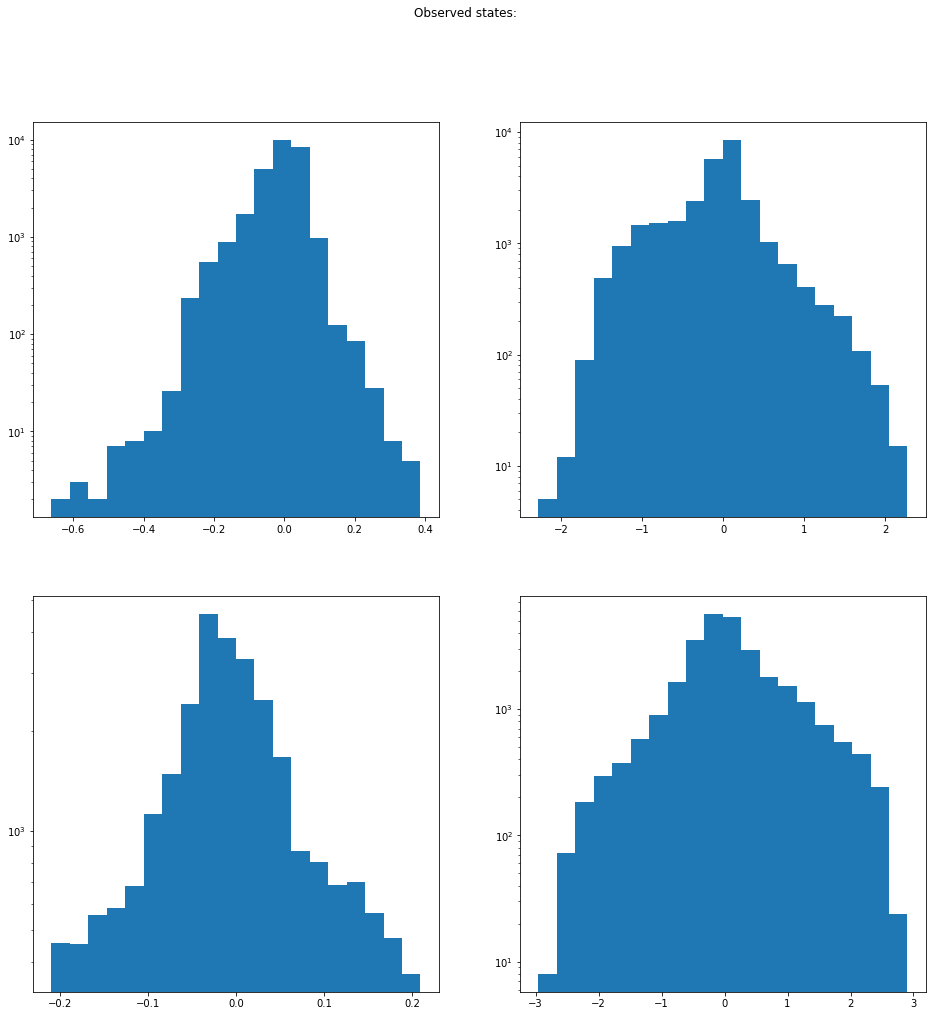

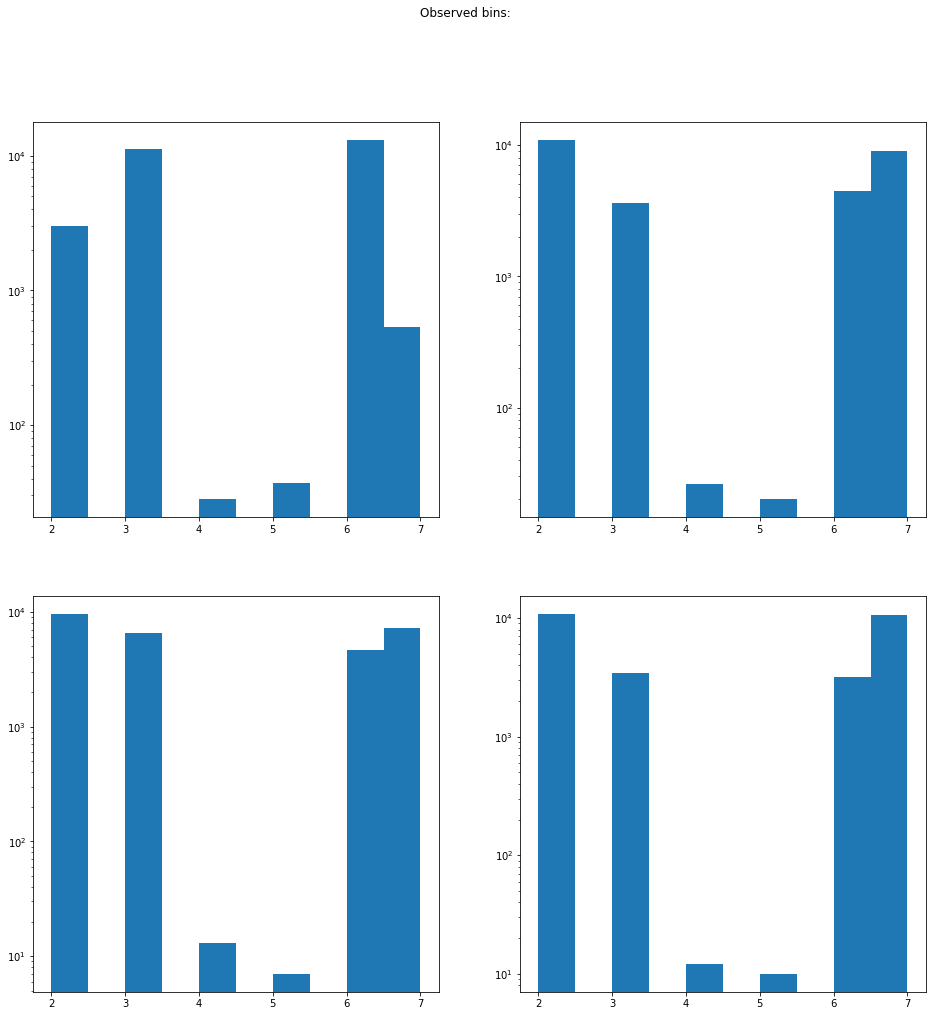

Shape of Q Table:  (10, 10, 10, 10, 2)
Original obs [-0.04169625 -0.03034753  0.0039724  -0.02382357] --> binned (3, 3, 6, 3)
Value of Q Table at that obs/state value [ 0.88636072 26.61851254]


Best R:  28.799


In [45]:
# Convert (S, A) to a tuple for indexing into Q
def saTuple(s, a):
    return tuple(s) + (a,)

# Initialize Q
def buildQ(num_bins):
    qShape = [num_bins]*len(obs)+[env.action_space.n]
    Q = np.random.uniform(low=0, high=1, size=qShape)
    # Boundary bins:
    Q[ 0,  :,  :,  :, 0] = 0
    Q[ 0,  :,  :,  :, 1] = 0
    Q[-1,  :,  :,  :, 0] = 0
    Q[-1,  :,  :,  :, 1] = 0
    Q[ :,  0,  :,  :, 0] = 0
    Q[ :,  0,  :,  :, 1] = 0
    Q[ :, -1,  :,  :, 0] = 0
    Q[ :, -1,  :,  :, 1] = 0
    Q[ :,  :,  0,  :, 0] = 0
    Q[ :,  :,  0,  :, 1] = 0
    Q[ :,  :, -1,  :, 0] = 0
    Q[ :,  :, -1,  :, 1] = 0
    Q[ :,  :,  :,  0, 0] = 0
    Q[ :,  :,  :,  0, 1] = 0
    Q[ :,  :,  :, -1, 0] = 0
    Q[ :,  :,  :, -1, 1] = 0
    return Q

def getAverageQReward(num_bins=10, alpha=0.1, gamma=0.99, log_n=1000, eps=0.05, initQ=None):
    # set eps to None for purely greedy
    Q = initQ if initQ is not None else buildQ(num_bins)
    obs2bin = setupQ(Q, num_bins, alpha, gamma, log_n, eps)
    
    # action = optimal if np.random.rand() > eps else random
    def epsGreedyPickFunc(env, lastObs):
        # random pick:
        if eps is not None and np.random.random() <= eps:
            return randomPick(env, lastObs)
        # otherwise, best:
        else:
            bins = obs2bin(lastObs)
            q0 = Q[saTuple(bins, 0)]
            q1 = Q[saTuple(bins, 1)]
            return 0 if q0 >= q1 else 1

    # Update Q
    def qUpdate(s_old, a, r, s_new):
        b_old, b_new = obs2bin(s_old), obs2bin(s_new)
        _observedBins.append(b_old)
        _observedStates.append(s_old)
        t_old = saTuple(b_old, a)

        maxQ = max(Q[saTuple(b_new, 0)], Q[saTuple(b_new, 1)])
        Q[t_old] += alpha * (r + gamma * maxQ - Q[t_old])        
        
        #if b_old[0] == 3 and b_old[2] == 3:
        #    f, ax = plt.subplots(1, 2)
        #    ax[0].imshow(Q[3, :, 3, :, 0])
        #    ax[1].imshow(Q[3, :, 3, :, 1])
        #    plt.show()

    _observedBins = []
    _observedStates = []
    reward = getAverageReward(epsGreedyPickFunc, updateFunc=qUpdate, nRuns=1000)
    return reward, Q, np.array(_observedBins), np.array(_observedStates)

nBins=10
_r, _q, oBins, oStates = getAverageQReward(num_bins=nBins)
print (_r)


import matplotlib.pyplot as plt

f, ax = plt.subplots(2, 2, figsize=(16, 16))
f.suptitle("Observed states:")
ax[0][0].hist(oStates[:, 0], log=True, bins=2*nBins)
ax[0][1].hist(oStates[:, 1], log=True, bins=2*nBins)
ax[1][0].hist(oStates[:, 2], log=True, bins=2*nBins)
ax[1][1].hist(oStates[:, 3], log=True, bins=2*nBins)
plt.show()


f, ax = plt.subplots(2, 2, figsize=(16, 16))
f.suptitle("Observed bins:")
ax[0][0].hist(oBins[:, 0], log=True, bins=nBins)
ax[0][1].hist(oBins[:, 1], log=True, bins=nBins)
ax[1][0].hist(oBins[:, 2], log=True, bins=nBins)
ax[1][1].hist(oBins[:, 3], log=True, bins=nBins)
plt.show()


bestRun, _, _, _ = getAverageQReward(num_bins=nBins, eps=None, initQ = _q)
print ("Best R: ", bestRun)


## 4. Experiments [20 pts]

Given a working algorithm, you will run a few experiments.  Either make a copy of your code above to modify, or make the modifications in a way that they can be commented out or switched between (with boolean flag if statements).

**4.2. [10pts] $\epsilon$-greedy.**  How sensitive are the results to the value of $\epsilon$?   First, write down your prediction of what would happen if $\epsilon$ is set to various values, including for example [0, 0.05, 0.25, 0.5].

TODO: answer here

Now run the experiment and observe the impact on the algorithm.  Report the results below.

TODO: answer here

**4.3. [10pts] Design your own experiment.** Design a modification that you think would either increase or reduce performance.  A simple example (which you can use) is initializing the Q-table differently, and thinking about how this might alter performance. Write down your idea, what you think might happen, and why.

TODO: answer here

Run the experiment and report the results.

TODO: answer here

---

## A. Extensions (optional)

- plots your learning curve, using e.g., matplotlib 
- visualize the Q-table to see which values are being updated and not
- design a better binning strategy that uses fewer bins for a better-performing policy
- extend this approach to work on different environments (e.g., LunarLander-v2)
- extend this approach to work on environments with continuous actions, by using a fixed set of discrete samples of the action space.  e.g., for Pendulum-v0
- implement a simple deep learning version of this.  we will see next homework that DQN uses some tricks to make the neural network training more stable.  Experiment directly with simply replacing the Q-table with a Q-Network and train the Q-Network using gradient descent with `loss = (targets - Q(s,a))**2`, where `targets = stop_grad(R + gamma * maxa(Q(s,a))`).